# DataKind Red Cross Project Phase 2
## Home Fire Risk Data Model
10/28/2019
Tasks:
1. <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
2. <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
3. <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.
4. <b>Home Fire Severity Assessment (census tract)</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates
5. <b>Home Fire Predictablility Assessment</b>: Using Census Tract Fire Severity Assesment bin Data at 3-month 6-month or 1-year intervals and train simple linear/logistic regression model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

# Data Import and Cleaning

## NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [2]:
nfirs_path = '../data/raw/NFIRS_2009_2016_Combined_Census_Tract.csv'

cols_to_use = ['state','fdid','city','zip5','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Fix the tot_loss column which had incorrect data for 2015. Since tot_loss = prop_loss + cont_loss, it was easy enough to recalculate those values
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

In [4]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [5]:
nfirs.sample(5)

,state,fdid,city,zip5,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire
1861544,NY,28001,Rochester,14616,2016-01-28,NaN,NaN,NaN,NaN,NaN,36055013601.0,not_sev_fire
1106537,NJ,2210,Garfield,7026,2013-04-07,NaN,NaN,0.0,0.0,0.0,34003021400.0,not_sev_fire
1739016,FL,4042,CLEARWATER,33759,2016-05-12,NaN,NaN,0.0,0.0,0.0,12103026818.0,not_sev_fire
1670640,MI,08207,Detroit,48206,2015-11-10,NaN,NaN,500.0,250.0,750.0,26163530500.0,not_sev_fire
464122,TX,SA416,The Woodlands,77380,2010-08-18,0.0,0.0,40000.0,40000.0,80000.0,48339691601.0,sev_fire


## Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [6]:
nfirs['GEOID'].str.len().value_counts()

13.0    1442479
12.0     196432
Name: GEOID, dtype: int64

In [7]:
nfirs['GEOID'] = (nfirs['GEOID'].str[:-2]
                  .str.zfill(11))

In [8]:
nfirs.head()

,state,fdid,city,zip5,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID,severe_fire
0,AK,11100,JUNEAU,99801,2009-01-03,0.0,0.0,20000.0,5000.0,25000.0,02110000500,sev_fire
1,AK,11100,JUNEAU,99801,2009-01-06,0.0,0.0,0.0,0.0,0.0,02110000600,not_sev_fire
2,AK,11100,JUNEAU,99801,2009-01-06,0.0,0.0,20000.0,5000.0,25000.0,02110000100,sev_fire
3,AK,11100,JUNEAU,99801,2009-01-13,0.0,0.0,200.0,20.0,220.0,02110000400,not_sev_fire
4,AK,11100,JUNEAU,99801,2009-01-21,0.0,0.0,35000.0,5000.0,40000.0,02110000400,sev_fire


In [9]:
# Add a year column to be used to groupby in addition to GEOID
nfirs['year'] = nfirs['inc_date'].dt.year

## SVI Data

In [10]:
svi2016_path = '../data/raw/SVI2016_US.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     index_col=0,
                     dtype = svi_col_dtypes)

In [11]:
svi2016.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
FID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,01,ALABAMA,AL,01015,Calhoun,01015981902,"Census Tract 9819.02, Calhoun County, Alabama",34.644448,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,335.0
1,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.929908,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0
2,01,ALABAMA,AL,01097,Mobile,01097990000,"Census Tract 9900, Mobile County, Alabama",0.000000,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0


# Tasks 1 & 3

- Task 1: <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 3: <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.

In [12]:
# add the state+county unique identifier column to nfirs
nfirs['STCNTY'] = nfirs['GEOID'].str[:5]

# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_counties = pd.crosstab(nfirs['STCNTY'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_counties[(year,'tot_fires')] = nfirs_counties[(year,'not_sev_fire')] + nfirs_counties[(year,'sev_fire')]

# Sort the columns
nfirs_counties = nfirs_counties[sorted(nfirs_counties.columns)]

# aggregate svi data by county
svi2016_counties = svi2016.groupby('STCNTY').agg({'E_TOTPOP':'sum'})

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_counties = svi2016_counties.merge(nfirs_counties,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_counties_rates = nfirs_svi_counties[['E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_counties_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_counties[(year,'tot_fires')] / nfirs_svi_counties['E_TOTPOP']
    nfirs_svi_counties_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_counties[(year,'sev_fire')] / nfirs_svi_counties['E_TOTPOP']

# Add the county and state columns to the dataset
nfirs_svi_counties_rates = nfirs_svi_counties_rates.merge(svi2016[['COUNTY','ST_ABBR','STCNTY']].drop_duplicates(subset='STCNTY'),how='left',left_index=True,right_on='STCNTY')
nfirs_svi_counties_rates = nfirs_svi_counties_rates.set_index('STCNTY')

# create list of severe columns & total columns
sev_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_counties_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].mean(axis=1)
nfirs_svi_counties_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_counties_rates[sev_cols].std(axis=1)
nfirs_svi_counties_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].mean(axis=1)
nfirs_svi_counties_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_counties_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_counties_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_counties_rates = nfirs_svi_counties_rates[cols]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [13]:
nfirs_svi_counties_rates.head()

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
01001,AL,Autauga,55049.0,0.000459,0.000164,0.000123,0.000070,0.000708,0.000236,0.000490,0.000163,0.000527,0.000127,0.000254,0.000036,0.000436,0.000073,0.000200,0.000036,0.000563,0.000163,0.000490,0.000145
01003,AL,Baldwin,199510.0,0.000465,0.000099,0.000082,0.000023,0.000366,0.000080,0.000471,0.000075,0.000381,0.000100,0.000441,0.000065,0.000396,0.000050,0.000677,0.000125,0.000501,0.000085,0.000486,0.000075
01005,AL,Barbour,26614.0,0.000244,0.000143,0.000070,0.000093,0.000376,0.000113,0.000451,0.000000,0.000150,0.000000,0.000301,0.000188,0.000038,0.000000,0.000338,0.000225,0.000113,0.000000,0.000188,0.000038
01007,AL,Bibb,22572.0,0.000072,0.000062,0.000033,0.000031,0.000044,0.000044,0.000044,0.000044,0.000089,0.000044,0.000177,0.000044,0.000000,0.000000,0.000000,0.000000,0.000089,0.000000,0.000133,0.000089
01009,AL,Blount,57704.0,0.000390,0.000196,0.000095,0.000060,0.000364,0.000069,0.000399,0.000069,0.000468,0.000243,0.000277,0.000087,0.000208,0.000069,0.000295,0.000069,0.000277,0.000069,0.000832,0.000087


In [31]:
nfirs_svi_counties_rates.sort_values('avg_tot_fire_rate_per_cap',ascending=False)

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
25025,MA,Suffolk,767719.0,0.004143,0.000239,0.000236,0.000021,0.004113,0.000223,0.004129,0.000225,0.004004,0.000225,0.003859,0.000215,0.004094,0.000276,0.004298,0.000225,0.004001,0.000258,0.004645,0.000242
36005,NY,Bronx,1436785.0,0.002924,0.000339,0.000034,0.000008,0.003026,0.000026,0.003064,0.000032,0.002359,0.000023,0.002431,0.000031,0.002946,0.000040,0.003227,0.000031,0.003167,0.000040,0.003171,0.000047
05069,AR,Jefferson,72385.0,0.002787,0.000745,0.000927,0.000367,0.002349,0.000815,0.003260,0.001299,0.002956,0.000995,0.003081,0.001188,0.002929,0.000939,0.003398,0.001243,0.003205,0.000787,0.001119,0.000152
28119,MS,Quitman,7634.0,0.002685,0.000697,0.000982,0.000336,0.002620,0.000655,0.002358,0.001048,0.001703,0.000655,0.003668,0.001310,0.002227,0.001048,0.002227,0.000655,0.003144,0.000917,0.003537,0.001572
05095,AR,Monroe,7542.0,0.002536,0.000794,0.001326,0.000554,0.003050,0.001061,0.001326,0.000663,0.002519,0.001193,0.002652,0.001724,0.002519,0.001724,0.003580,0.001326,0.003182,0.002254,0.001458,0.000663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49009,UT,Daggett,751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49019,UT,Grand,9428.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49031,UT,Piute,1859.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
nfirs_svi_counties_rates.sort_values('avg_sev_fire_rate_per_cap',ascending=False)

,ST_ABBR,COUNTY,E_TOTPOP,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
05095,AR,Monroe,7542.0,0.002536,0.000794,0.001326,0.000554,0.003050,0.001061,0.001326,0.000663,0.002519,0.001193,0.002652,0.001724,0.002519,0.001724,0.003580,0.001326,0.003182,0.002254,0.001458,0.000663
28119,MS,Quitman,7634.0,0.002685,0.000697,0.000982,0.000336,0.002620,0.000655,0.002358,0.001048,0.001703,0.000655,0.003668,0.001310,0.002227,0.001048,0.002227,0.000655,0.003144,0.000917,0.003537,0.001572
28063,MS,Jefferson,7528.0,0.001196,0.001311,0.000963,0.000962,0.000266,0.000266,0.000133,0.000133,0.000531,0.000531,0.000000,0.000000,0.000930,0.000930,0.002922,0.002790,0.001328,0.001196,0.003454,0.001860
51730,VA,Petersburg City,31997.0,0.002410,0.000415,0.000949,0.000267,0.002594,0.000781,0.002782,0.001156,0.002094,0.000844,0.002438,0.001000,0.002250,0.001000,0.003063,0.001406,0.002344,0.000906,0.001719,0.000500
05111,AR,Poinsett,24131.0,0.002098,0.000283,0.000938,0.000157,0.002445,0.000995,0.002196,0.000870,0.001906,0.000912,0.002362,0.000953,0.001658,0.000704,0.002362,0.001243,0.001948,0.000829,0.001906,0.000995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49009,UT,Daggett,751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49019,UT,Grand,9428.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49031,UT,Piute,1859.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Save fire rates by county

In [14]:
# nfirs_svi_counties_rates.to_csv('../data/processed/Per_capita_fire_rates_by_county.csv')

# Tasks 2 & 4

- Task 2: <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
- Task 4: <b>Home Fire Severity Assessment (census tract)</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population 

In [15]:
# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_tracts = pd.crosstab(nfirs['GEOID'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in nfirs['year'].unique():
    nfirs_tracts[(year,'tot_fires')] = nfirs_tracts[(year,'not_sev_fire')] + nfirs_tracts[(year,'sev_fire')]

# Sort the columns
nfirs_tracts = nfirs_tracts[sorted(nfirs_tracts.columns)]

# data already aggregated by census tract, so simply select the columns to merge
svi2016_tracts = svi2016[['FIPS','ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].set_index('FIPS')

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_tracts = svi2016_tracts.merge(nfirs_tracts,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_tracts_rates = nfirs_svi_tracts[['ST_ABBR','COUNTY','LOCATION','E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_tracts_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'tot_fires')] / nfirs_svi_tracts['E_TOTPOP']
    nfirs_svi_tracts_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_tracts[(year,'sev_fire')] / nfirs_svi_tracts['E_TOTPOP']

nfirs_svi_tracts_rates.index.name = 'GEOID'

# create list of severe columns & total columns
sev_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_tracts_rates.columns[nfirs_svi_tracts_rates.columns.str.contains('tot_')]

# calculate mean and standard deviation from 2009-2016
nfirs_svi_tracts_rates['avg_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_sev_fire_rate_per_cap'] = nfirs_svi_tracts_rates[sev_cols].std(axis=1)
nfirs_svi_tracts_rates['avg_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].mean(axis=1)
nfirs_svi_tracts_rates['std_tot_fire_rate_per_cap'] = nfirs_svi_tracts_rates[tot_cols].std(axis=1)

# Rearrange columns
first_cols = ['ST_ABBR','COUNTY','E_TOTPOP','LOCATION','avg_tot_fire_rate_per_cap','std_tot_fire_rate_per_cap',
              'avg_sev_fire_rate_per_cap','std_sev_fire_rate_per_cap']
cols = list(nfirs_svi_tracts_rates.columns)
cols = first_cols + [col for col in cols if col not in first_cols]
nfirs_svi_tracts_rates = nfirs_svi_tracts_rates[cols]

In [16]:
nfirs_svi_tracts_rates.sample(5)

,ST_ABBR,COUNTY,E_TOTPOP,LOCATION,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
GEOID,,,,,,,,,,,,,,,,,,,,,,,,
25013813301,MA,Hampden,7498.0,"Census Tract 8133.01, Hampden County, Massachu...",0.001000,0.000410,0.000283,0.000166,0.000934,0.0004,0.000800,0.000133,0.001734,0.000400,0.000800,0.000267,0.000533,0.000000,0.000667,0.000267,0.001467,0.000533,0.001067,0.000267
09011696800,CT,New London,3581.0,"Census Tract 6968, New London County, Connecticut",0.003840,0.001777,0.000035,0.000099,0.005027,0.0000,0.005585,0.000000,0.004468,0.000000,0.005306,0.000279,0.004747,0.000000,0.000838,0.000000,0.003072,0.000000,0.001676,0.000000
01099076000,AL,Monroe,3251.0,"Census Tract 760, Monroe County, Alabama",0.000807,0.000837,0.000077,0.000218,0.002461,0.0000,0.000308,0.000000,0.000615,0.000000,0.000615,0.000000,0.001538,0.000615,0.000923,0.000000,0.000000,0.000000,0.000000,0.000000
55097961000,WI,Portage,2857.0,"Census Tract 9610, Portage County, Wisconsin",0.001050,0.000954,0.000219,0.000416,0.001050,0.0007,0.000000,0.000000,0.002450,0.000000,0.001050,0.000000,0.000700,0.000000,0.000000,0.000000,0.000700,0.000000,0.002450,0.001050
22103040602,LA,St. Tammany,2685.0,"Census Tract 406.02, St. Tammany Parish, Louis...",0.000745,0.000398,0.000186,0.000282,0.000745,0.0000,0.000745,0.000000,0.000372,0.000372,0.000372,0.000000,0.000745,0.000372,0.000372,0.000000,0.001490,0.000745,0.001117,0.000000


In [41]:
(nfirs_svi_tracts_rates[nfirs_svi_tracts_rates['avg_tot_fire_rate_per_cap'] != np.inf]
 .sort_values('avg_tot_fire_rate_per_cap',ascending=False)
 .head())

,ST_ABBR,COUNTY,E_TOTPOP,LOCATION,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
GEOID,,,,,,,,,,,,,,,,,,,,,,,,
36119000104,NY,Westchester,20.0,"Census Tract 1.04, Westchester County, New York",0.181250,0.210336,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.400000,0.0,0.5,0.0,0.000000,0.0,0.350000,0.0,0.200000,0.0
36061021703,NY,New York,8.0,"Census Tract 217.03, New York County, New York",0.109375,0.104315,0.000000,0.000000,0.250000,0.0,0.000000,0.0,0.125000,0.000000,0.125000,0.0,0.0,0.0,0.000000,0.0,0.250000,0.0,0.125000,0.0
36061014300,NY,New York,5.0,"Census Tract 143, New York County, New York",0.075000,0.103510,0.000000,0.000000,0.000000,0.0,0.200000,0.0,0.200000,0.000000,0.200000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
36061009400,NY,New York,44.0,"Census Tract 94, New York County, New York",0.056818,0.052953,0.000000,0.000000,0.045455,0.0,0.136364,0.0,0.022727,0.000000,0.136364,0.0,0.0,0.0,0.022727,0.0,0.022727,0.0,0.068182,0.0
48201980000,TX,Harris,9.0,"Census Tract 9800, Harris County, Texas",0.055556,0.059391,0.013889,0.039284,0.111111,0.0,0.000000,0.0,0.111111,0.111111,0.000000,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.000000,0.0


In [42]:
(nfirs_svi_tracts_rates[nfirs_svi_tracts_rates['avg_sev_fire_rate_per_cap'] != np.inf]
 .sort_values('avg_sev_fire_rate_per_cap',ascending=False)
 .head())

,ST_ABBR,COUNTY,E_TOTPOP,LOCATION,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
GEOID,,,,,,,,,,,,,,,,,,,,,,,,
26099982000,MI,Macomb,5.0,"Census Tract 9820, Macomb County, Michigan",0.025000,0.070711,0.025000,0.070711,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48201980000,TX,Harris,9.0,"Census Tract 9800, Harris County, Texas",0.055556,0.059391,0.013889,0.039284,0.111111,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000
26163508100,MI,Wayne,1155.0,"Census Tract 5081, Wayne County, Michigan",0.019372,0.012112,0.011580,0.007418,0.019048,0.012121,0.015584,0.009524,0.005195,0.003463,0.012987,0.006926,0.031169,0.021645,0.021645,0.011255,0.041558,0.023377,0.007792,0.004329
04013980400,AZ,Maricopa,12.0,"Census Tract 9804, Maricopa County, Arizona",0.010417,0.029463,0.010417,0.029463,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26163507900,MI,Wayne,1443.0,"Census Tract 5079, Wayne County, Michigan",0.019491,0.012465,0.010222,0.006798,0.009702,0.006237,0.023562,0.009702,0.006237,0.004158,0.012474,0.002772,0.018711,0.011088,0.045045,0.023562,0.027027,0.015939,0.013167,0.008316


### Save fire rates by census_tract

In [17]:
# nfirs_svi_tracts_rates.to_csv('../data/processed/Per_capita_fire_rates_by_census_tract.csv')

# Task 5
- Task 5: <b>Home Fire Predictablility Assessment</b>: Using Census Tract Fire Severity Assesment bin Data at 3-month 6-month or 1-year intervals and train simple linear/logistic regression model

1 year intervals will be used to capture the temporal aspect of the data, which occurs at one year intervals (most fires occur during the winter months)

## Plotting correlation coefficients

In [18]:
def plot_correlation_matrix_heat_map(df,label,qty_fields=10):
    df = pd.concat([df[label],df.drop(label,axis=1)],axis=1)
    correlation_matrix = df.corr()
    index = correlation_matrix.sort_values(label, ascending=False).index
    correlation_matrix = correlation_matrix[index].sort_values(label,ascending=False)

    fig,ax = plt.subplots()
    fig.set_size_inches((10,10))
    sns.heatmap(correlation_matrix.iloc[:qty_fields,:qty_fields],annot=True,fmt='.2f',ax=ax)
    return(fig,ax)

### County correlation heat maps

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2029388f2c8>)

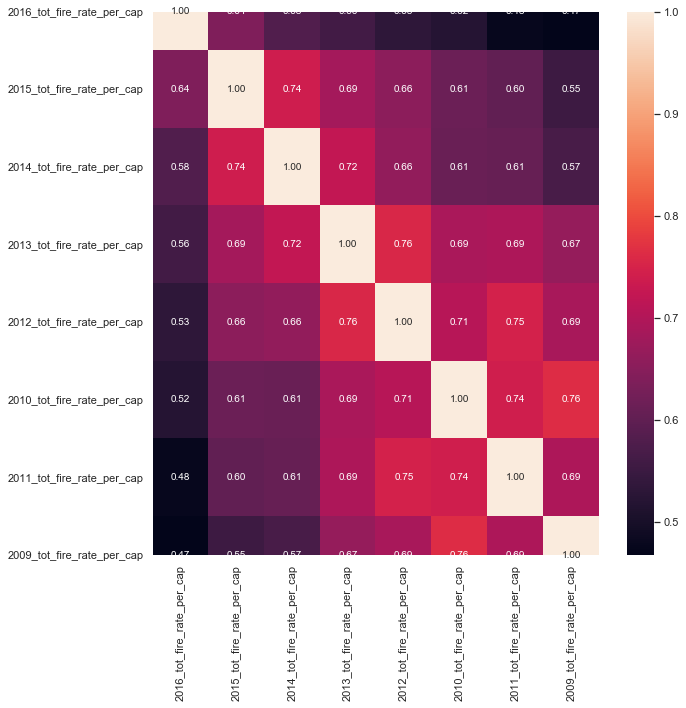

In [19]:
plot_correlation_matrix_heat_map(nfirs_svi_counties_rates[tot_cols],'2016_tot_fire_rate_per_cap')

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x202bb21fa08>)

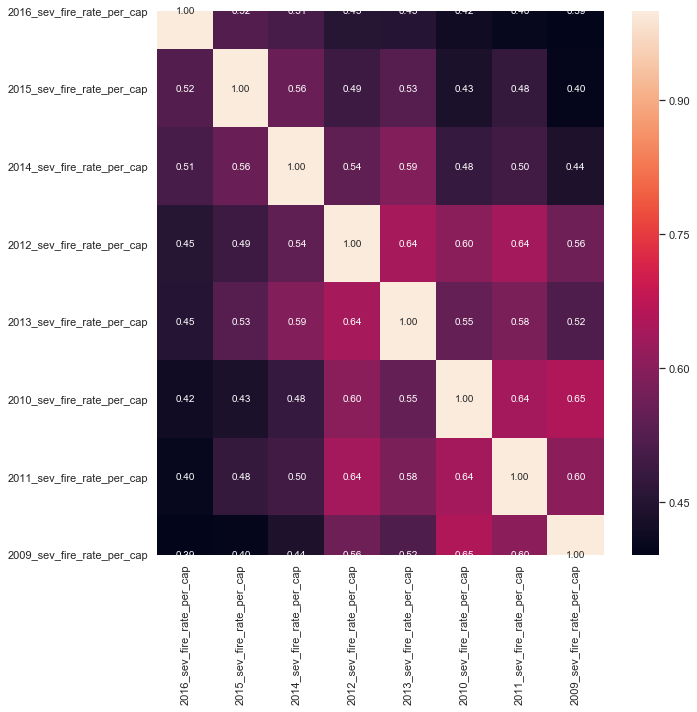

In [20]:
plot_correlation_matrix_heat_map(nfirs_svi_counties_rates[sev_cols],'2016_sev_fire_rate_per_cap')

### Census tract correlation heat maps

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x202bc325448>)

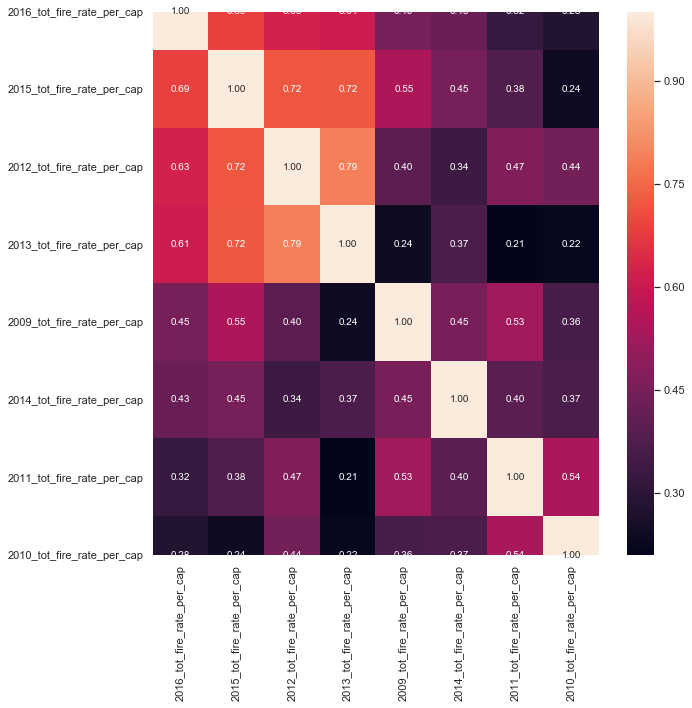

In [21]:
plot_correlation_matrix_heat_map(nfirs_svi_tracts_rates[tot_cols],'2016_tot_fire_rate_per_cap')

## Linear Regression Model

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

I'll use the yearly aggregated rates to create a simple linear regression algorithm to predict the rate for 2016 by census tract

In [23]:
def null_counts(df):
    null_df = pd.DataFrame(df.isnull().sum(),columns=['null_count'])
    null_df['null_fraction'] = null_df['null_count'] / df.shape[0]
    null_df = null_df.sort_values('null_count',ascending=False)
    return null_df

In [24]:
null_counts(nfirs_svi_tracts_rates)

,null_count,null_fraction
2013_sev_fire_rate_per_cap,4750,0.065215
std_tot_fire_rate_per_cap,4750,0.065215
2012_sev_fire_rate_per_cap,4750,0.065215
std_sev_fire_rate_per_cap,4750,0.065215
2009_sev_fire_rate_per_cap,4750,0.065215
2014_sev_fire_rate_per_cap,4749,0.065201
2010_sev_fire_rate_per_cap,4749,0.065201
2011_sev_fire_rate_per_cap,4748,0.065188
2016_sev_fire_rate_per_cap,4747,0.065174
2009_tot_fire_rate_per_cap,4747,0.065174


In [25]:
tot_cols

Index(['2009_tot_fire_rate_per_cap', '2010_tot_fire_rate_per_cap',
       '2011_tot_fire_rate_per_cap', '2012_tot_fire_rate_per_cap',
       '2013_tot_fire_rate_per_cap', '2014_tot_fire_rate_per_cap',
       '2015_tot_fire_rate_per_cap', '2016_tot_fire_rate_per_cap'],
      dtype='object')

In [26]:
label = '2016_tot_fire_rate_per_cap'
# features = tot_cols.drop(label)
features = ['2014_tot_fire_rate_per_cap','2015_tot_fire_rate_per_cap']

X_train, X_test, y_train, y_test = train_test_split(nfirs_svi_tracts_rates.dropna()[features],nfirs_svi_tracts_rates.dropna()[label],train_size=.8,random_state=1)

In [27]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train,random_state=1)

In [28]:
lr = LinearRegression()
lr.fit(X_train2,y_train2)
lr.score(X_train2,y_train2)

0.6103114199095088

In [29]:
lr = LinearRegression()
cross_val_score(lr,X_train,y_train,cv=10)

array([ 0.43255515,  0.34956002,  0.38157443,  0.77108122,  0.42177448,
        0.68032207,  0.35967215, -0.15691824,  0.45037743,  0.37971549])

In [30]:
nfirs_svi_tracts_rates.sample(5,random_state=1)

,ST_ABBR,COUNTY,E_TOTPOP,LOCATION,avg_tot_fire_rate_per_cap,std_tot_fire_rate_per_cap,avg_sev_fire_rate_per_cap,std_sev_fire_rate_per_cap,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap
GEOID,,,,,,,,,,,,,,,,,,,,,,,,
36063022100,NY,Niagara,2360.0,"Census Tract 221, Niagara County, New York",0.000583,0.000503,0.000106,0.000196,0.000847,0.000424,0.000000,0.000000,0.000000,0.000000,0.001271,0.000000,0.000847,0.000424,0.000000,0.000000,0.000847,0.000000,0.000847,0.000000
36005002800,NY,Bronx,5350.0,"Census Tract 28, Bronx County, New York",0.002126,0.000519,0.000000,0.000000,0.002430,0.000000,0.001495,0.000000,0.001308,0.000000,0.002243,0.000000,0.002430,0.000000,0.002430,0.000000,0.002804,0.000000,0.001869,0.000000
27109002100,MN,Olmsted,6400.0,"Census Tract 21, Olmsted County, Minnesota",0.000078,0.000221,0.000020,0.000055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000625,0.000156,0.000000,0.000000,0.000000,0.000000
36047089800,NY,Kings,1676.0,"Census Tract 898, Kings County, New York",0.007757,0.008775,0.000149,0.000276,0.002387,0.000000,0.001193,0.000000,0.001193,0.000000,0.001193,0.000000,0.001193,0.000000,0.016706,0.000000,0.019690,0.000597,0.018496,0.000597
39093010300,OH,Lorain,5416.0,"Census Tract 103, Lorain County, Ohio",0.000923,0.000503,0.000162,0.000154,0.000554,0.000000,0.002031,0.000185,0.000739,0.000369,0.001108,0.000369,0.000554,0.000185,0.000739,0.000185,0.001108,0.000000,0.000554,0.000000
